In [4]:
%load_ext autoreload
%autoreload 2

from spelke_net.predictor.flow_predictor import LRASFlowPredictor
import h5py as h5
from spelke_net.utils.camera import pose_list_to_matrix
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 📦 Load SpelkeNet Model ##

In [5]:
model_name = 'SpelkeNet7B.pt'
device = 'cuda:4'

predictor = LRASFlowPredictor(
        model_name, 'rgb_quantizer.pt', 'flow_quantizer.pt', device=device
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████▉| 29.8G/29.8G [11:38<00:00, 70.4MiB/s]

Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/SpelkeNet7B.pt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 29.8G/29.8G [12:58<00:00, 38.3MiB/s]

|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| SpelkeNet7B.pt                                  |
|-------------------------------------------------|
| 📂 Model loaded from:                           |
| /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out |
|-------------------------------------------------|
| 🔢 7357.1M parameters in the model              |
|-------------------------------------------------|


Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/rgb_quantizer.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| rgb_quantizer.pt                                |
|-------------------------------------------------|
| 📂 Model loaded from:                           |
| /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out |
|-------------------------------------------------|
| 🔢 39.7M parameters in the model                |
|-------------------------------------------------|
Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/flow_quantizer.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| flow_quantizer.pt                               |
|------

## 🖼️ Load Input Image ##

Text(0.5, 1.0, 'Input image')

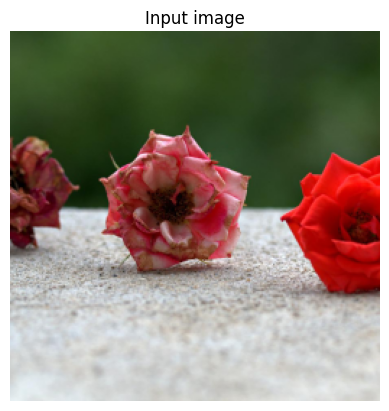

In [6]:
img = plt.imread('../demo_images/rose.png')[:, :, :3]
plt.imshow(img)
plt.axis('off')
plt.title('Input image')

## 🧭 Compute Motion Affordance ##

In [7]:
#set camera motion to zero: we want to understand the what parts of the scene will move upon external forces, independent of camera motion
campose = pose_list_to_matrix([0.0]*6)

#set the motion of the four corner to 0 to further refinforce a fixed camera
flow_cond = [[248,0,248,0],[0,0,0,0],[0,248,0,248],[248,248,248,248]]

#get prediction in parallel mode
preds = predictor.quantized_flow_prediction(
    img, campose=campose, flow_cond=flow_cond,
    num_seq_patches=0, mode="seq2par", seed=0,
)

#prob motion/motion affordance map
prob_map = 1 - preds["prob_no_motion"].cpu().numpy()

unmask_indices [31, 0, 992, 1023]


/ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/spelke_net/predictor/flow_predictor.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x: torch.tensor(x).permute(2,0,1) if len(x.shape) == 3 else torch.tensor(x).permute(0,3,1,2)),


## 🔍 Visualize Affordance Map ##

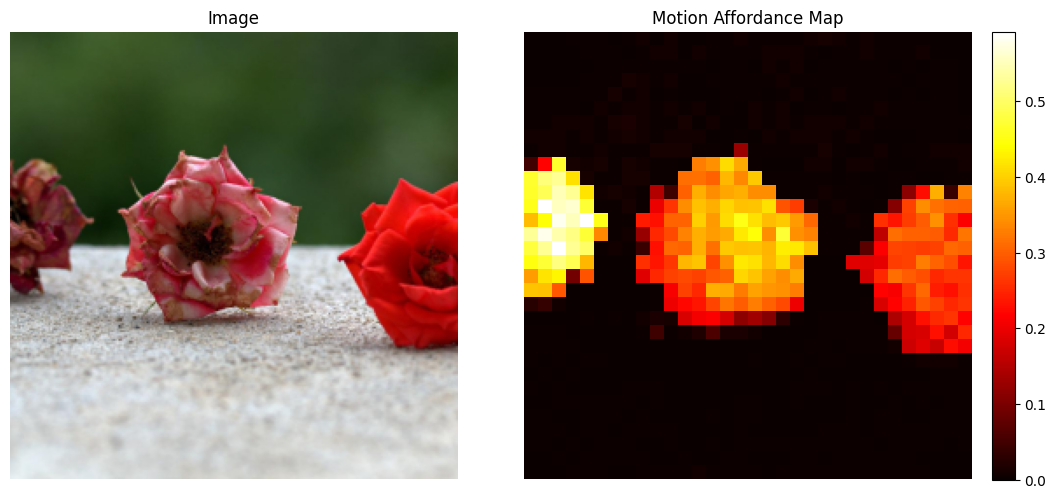

In [8]:
# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Show the original image
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Image")

# Show the probability of motion map
hm2 = axes[1].imshow(prob_map, cmap='hot')
axes[1].axis('off')
axes[1].set_title("Motion Affordance Map")

# Add colorbar for the heatmap
cbar2 = plt.colorbar(hm2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()